# Exploratory Data Analysis (EDA): Pre-LSTM Model Refinement 
Before architecture refinement or hyperparameter finetuning, you need to understand your data and its characteristics. For example, you should know the dimensions, distribution, quality, and variability of your data, as well as the potential sources of noise, bias, and outliers. You should also perform some exploratory data analysis and preprocessing to identify and handle missing values, duplicates, imbalances, and anomalies. Understanding your data will help you choose the appropriate data representation, normalization, augmentation, and splitting methods for your model.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import glob
import os
from utils.set_seed import set_seed
from utils.load_data import load_and_split_data
from utils.steady_state import find_steady_state, save_steady_state 
from visualisation.plots import *
from stats.report import statistical_report
from stats.autocorrelation import autocrosscorr
from models.lstm import LSTMClassifier
import ast 
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2


=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 13.6 min):
    - Mean mRNA Count: 10.06
    - Variance: 1231.56

  Normal Condition (after 12.8 min):
    - Mean mRNA Count: 10.01
    - Variance: 1184.56


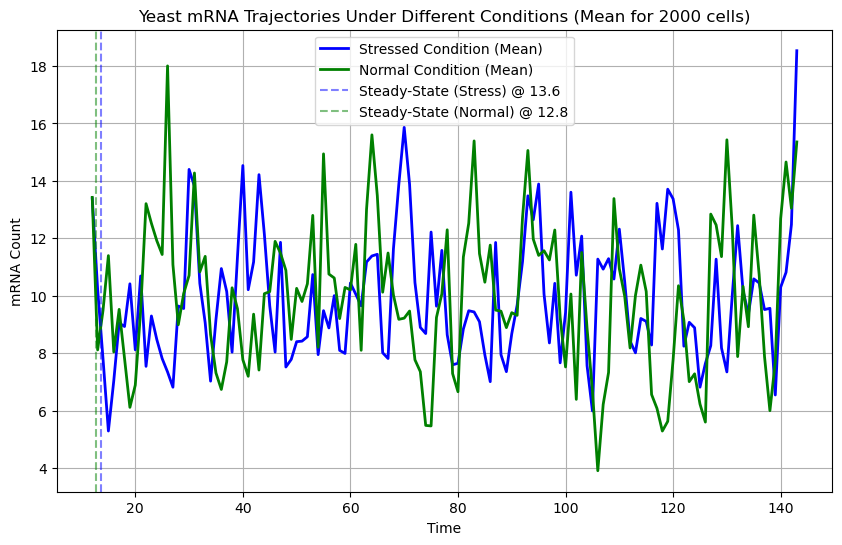

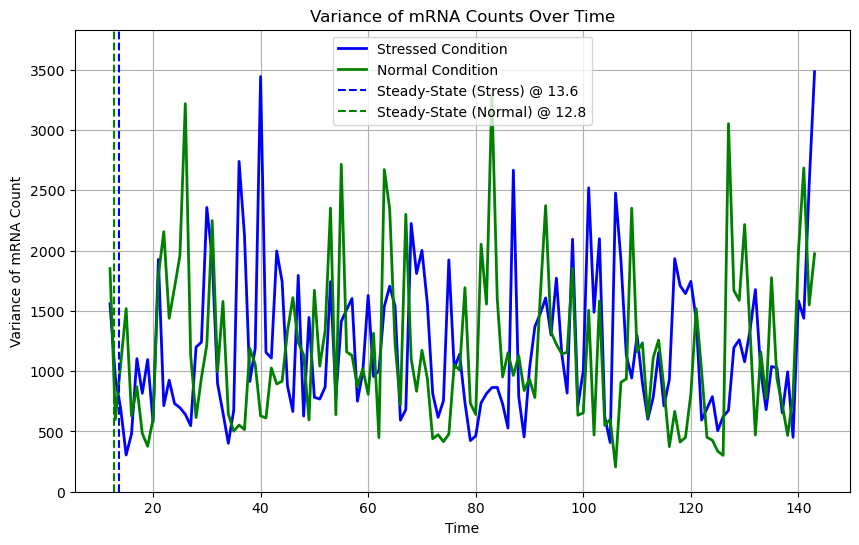


=== Variance at Steady State ===
  Stressed Condition (after 13.6 min): Mean = 10.06, Variance = 1231.56
  Normal Condition (after 12.8 min): Mean = 10.01, Variance = 1184.56


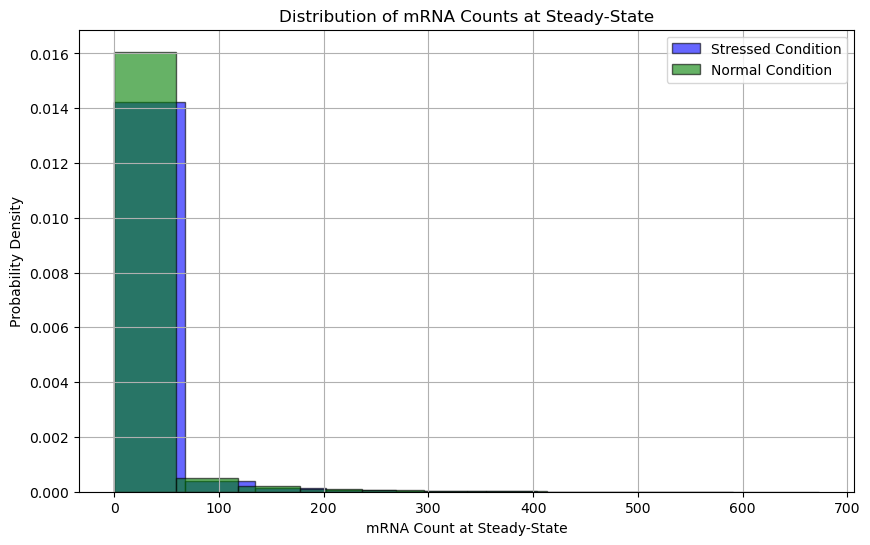

In [2]:
######## Get only the steady state series and save them

# extract the parameter sets
df_acc_results = pd.read_csv("data/accuracy_results_03_04_2025.csv")
parameter_sets = df_acc_results[df_acc_results['Variance Ratio'] == 0.9999999999999996]['Parameter Sets'].unique()
parameter_sets = ast.literal_eval(parameter_sets[0])

output_file = '/home/ianyang/stochastic_simulations/notebooks/data/mRNA_trajectories_variance_1199_1200/combined_traj_1199_1200.csv'
df_results = pd.read_csv(output_file)
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
remaining_time_points, steady_state_series = save_steady_state(output_file, parameter_sets, time_points)

# Extract mRNA trajectories for each condition
stress_trajectories = steady_state_series[steady_state_series['label'] == 0].iloc[:, 1:].values
normal_trajectories = steady_state_series[steady_state_series['label'] == 1].iloc[:, 1:].values

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
plot_mRNA_trajectory(parameter_sets, remaining_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, remaining_time_points, stress_trajectories, normal_trajectories)
# plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories, steady_state=True)

In [4]:
#### Load the steady state data and prepare it for LSTM
steady_state_file = os.path.join('data/steady_state_series/', f"{os.path.splitext(os.path.basename(output_file))[0]}_SS.csv") # this is the file name we saved it as
steady_state_df = pd.read_csv(steady_state_file)
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(steady_state_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
# Standardize the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# Reshape input for LSTM, LSTM expects input in the shape (batch_size, seq_len, num_features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

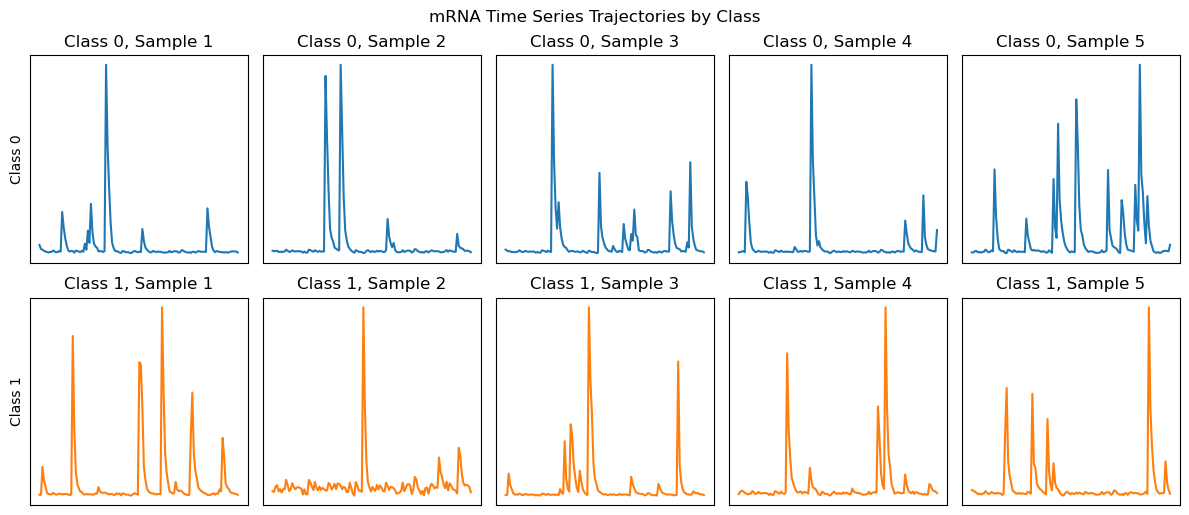

In [5]:
def plot_trajectories_by_class(X, y, num_samples=5):
    """
    Plot time series trajectories grouped by their class labels.
    """
    classes = np.unique(y)
    plt.figure(figsize=(12, len(classes) * 2.5))
    
    for i, cls in enumerate(classes):
        indices = np.where(y == cls)[0][:num_samples]
        for j, idx in enumerate(indices):
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.plot(X[idx].squeeze(), label=f'class {cls}', color='C'+str(cls))
            plt.title(f'Class {cls}, Sample {j+1}')
            plt.xticks([]); plt.yticks([])
            if j == 0:
                plt.ylabel(f'Class {cls}')
    
    plt.tight_layout()
    plt.suptitle("mRNA Time Series Trajectories by Class", y=1.02)
    plt.show()
plot_trajectories_by_class(X_train, y_train, num_samples=5)
